# Hierarchical MA-IDM

<img src="../Figs/Hierarchical_MA_IDM_PGM.png" width="480">

In [1]:
import arviz as az
import numpy as np
"""
# If pymc3
"""
# import pymc3 as pm
# from theano import tensor as tt
"""
# If pymc4
"""
import pymc as pm
import aesara.tensor as tt

import random
import pickle
import os
import sys
import matplotlib.pyplot as plt

sys.path.append('../')

from data.data_loader import read_training_data
from config import Config
from os import path
from pickle import UnpicklingError

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [2]:
def formalize_array(x, step, slice_len, skip, sliding_window=True):
    if sliding_window:
        N = int(np.floor((x.shape[0]-slice_len*step+1)/skip))
        x_all = np.zeros((N,slice_len))
        for i in range(N):
            x_all[i,:] = x[i*skip:i*skip+slice_len*step:step]
    else:
        x = x[: : step]
        N = int(np.floor(x.shape[0]/slice_len))
        x_all = np.zeros((N,slice_len))
        for i in range(N):
            x_all[i,:] = x[slice_len*i:slice_len*(i+1)]
    return x_all

def load_training_data(base_path, step, min_traj_lenth, skip, pair_id_list, N):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=min_traj_lenth)
    slice_len=int(4/(step*Config.dt))
    for pair_id in pair_id_list:
        if pair_id == pair_id_list[0]:
            vt = formalize_array(tracks[pair_id]['vFollReal'], step, slice_len, skip)
            s = formalize_array(tracks[pair_id]['sReal'], step, slice_len, skip)
            dv = formalize_array(tracks[pair_id]['dvReal'], step, slice_len, skip)
            label_v = formalize_array(tracks[pair_id]['vFollReal_next'], step, slice_len, skip)
            id_idx = N*np.ones_like(label_v, dtype=int)
        else:
            vt = np.vstack((vt,formalize_array(tracks[pair_id]['vFollReal'], step, slice_len, skip)))
            s = np.vstack((s,formalize_array(tracks[pair_id]['sReal'], step, slice_len, skip)))
            dv = np.vstack((dv, formalize_array(tracks[pair_id]['dvReal'], step, slice_len, skip)))
            label_v = np.vstack((label_v, formalize_array(tracks[pair_id]['vFollReal_next'], step, slice_len, skip)))
            id_idx = np.vstack((id_idx, N*np.ones_like(formalize_array(tracks[pair_id]['sReal'], step, slice_len, skip), dtype=int)))
        N += 1
    print("Traj length:",min_traj_lenth*Config.dt, ", ID list:", pair_id_list, ", Data size:", label_v.shape)
    return vt, s, dv, label_v, id_idx

def MA_IDM_hierarchical(base_path, step):
    # load interactive data for car
    vt, s, dv, label_v, id_idx = load_training_data(base_path, step, min_traj_lenth=50 * Config.frame_rate_orignial,
                                           skip=10, pair_id_list=Config.car_interactive_pair_list, N=0)
    # load interactive data for truck
    vt2, s2, dv2, label_v2, id_idx2 = load_training_data(base_path, step, min_traj_lenth=50 * Config.frame_rate_orignial,
                                               skip=10, pair_id_list=Config.truck_interactive_pair_list,
                                                         N=len(Config.car_interactive_pair_list))
    
    vt = np.vstack((vt,vt2))
    s = np.vstack((s, s2))
    dv = np.vstack((dv, dv2))
    label_v = np.vstack((label_v,label_v2))
    id_idx = np.vstack((id_idx,id_idx2))
    
    print("training size:", label_v.shape)
    ################################################
 
    dt = Config.dt
 
    D = 5
    
    N_veh = len(Config.car_interactive_pair_list)+len(Config.truck_interactive_pair_list)
    coords = {
    "veh_id": np.arange(N_veh),
    "obs_id": np.arange(label_v.shape[0]),
    "time_stamp": np.arange(label_v.shape[1]),
    }
   
    slice_len=int(4/(step*Config.dt))
    GP_t = np.array(range(slice_len*step))[::step].reshape(-1,1)
    shh = GP_t.shape[0]
  
    with pm.Model(coords=coords) as hierarchical_model:
        def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * tt.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * Config.dt
 
        id_idx = pm.ConstantData("id_idx", id_idx, dims=("obs_id","time_stamp"))
        s_ = pm.ConstantData("s", s, dims=("obs_id","time_stamp"))
        vt_ = pm.ConstantData("vt", vt, dims=("obs_id","time_stamp"))
        dv_ = pm.ConstantData("dv", dv, dims=("obs_id","time_stamp"))
        
        
        # Hyperpriors for group nodes
        chol, _, _ = pm.LKJCholeskyCov('chol', n=D, eta=2.0, sd_dist=pm.Exponential.dist(100.0, shape=D))
        cov = pm.Deterministic('cov', chol.dot(chol.T))

        vals_raw = pm.Normal('vals_raw',mu=0, sigma=1, shape=(N_veh, D), dims=('veh_id', ...))
        
        DELTA = 4
        
        log_mu = pm.Normal('log_mu', mu=0, sigma=1, shape=D)
        mu = pm.Deterministic('mu', tt.exp(log_mu))
        
        log_parameters = pm.Deterministic('log_mu_d', log_mu+tt.dot(chol,vals_raw.T).T)
        parameters = pm.Deterministic('mu_d', tt.exp(log_parameters))
        print("parameters.shape.eval():", parameters.shape.eval())
       
        #################################################
        # priors on the covariance function hyperparameters
        l = pm.Normal('l', mu=1*Config.frame_rate, sigma=1*Config.frame_rate)
 
        # Normal prior on the function variance
        s2_f = pm.Exponential('s2_f', lam=3e4)
        #################################################
        s2_a = pm.Exponential('s2_a', lam=1e5)
        
        
        cov_func = pm.gp.cov.ExpQuad(1, l)
        cov_obs = dt**2 * (s2_f* cov_func(GP_t)+s2_a*tt.eye(shh))

        # We normalize the IDM parameters according to the recommended parameters.
        v_obs = pm.MvNormal('obs',
                            mu=IDM_v(33*parameters[id_idx,0], 2*parameters[id_idx,1], 1.6*parameters[id_idx,2],
                                     1.5*parameters[id_idx,3], 1.67*parameters[id_idx,4],  DELTA, s_, vt_, dv_),
                            cov=cov_obs, observed=label_v, size=label_v.shape[0], dims=("obs_id","time_stamp"))
        tr = pm.sample(2500, tune=5000, random_seed=16, init='jitter+adapt_diag_grad', chains=2, cores=14,
                       discard_tuned_samples=True, return_inferencedata=True, target_accept=0.9)
       
    return tr, hierarchical_model

In [3]:
base_path = '../data/highD/'
step = 1
tr, model = MA_IDM_hierarchical(base_path, step)

Traj length: 250.0 , ID list: [14, 35, 23, 25, 36, 38, 60, 90, 228, 232] , Data size: (301, 20)
Traj length: 250.0 , ID list: [3, 4, 18, 52, 81, 144, 153, 162, 5, 241] , Data size: (289, 20)
training size: (590, 20)
parameters.shape.eval(): [20  5]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (2 chains in 14 jobs)
NUTS: [chol, vals_raw, log_mu, l, s2_f, s2_a]


Sampling 2 chains for 5_000 tune and 2_500 draw iterations (10_000 + 5_000 draws total) took 2691 seconds.


In [3]:
base_path = '../data/highD/'
cache = "../PGM_highD/cache/MA_IDM_hierarchical.pkl"

if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tr = pickle.load(fp)
        fp.close()
        print("Load trace", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    output_file = open(cache, 'wb')
    pickle.dump(tr, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

Load trace ../PGM_highD/cache/MA_IDM_hierarchical.pkl : done!


In [8]:
tr.posterior['mu'] = tr.posterior.mu[:,:,:] * [33, 2, 1.6, 1.5, 1.67]

In [9]:
az.summary(tr, var_names=["mu"]) # index 0-5 are: VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],17.185,1.113,15.255,19.347,0.019,0.014,3511.0,3324.0,1.0
mu[1],3.650,0.181,3.327,4.001,0.004,0.003,2066.0,2940.0,1.0
mu[2],1.129,0.086,0.971,1.295,0.002,0.002,1396.0,1980.0,1.0
mu[3],0.534,0.036,0.465,0.599,0.001,0.000,3896.0,3759.0,1.0
mu[4],1.978,0.210,1.615,2.406,0.004,0.003,3407.0,3033.0,1.0


In [4]:
print(np.sqrt(tr.posterior.s2_a.mean(axis=0).mean(axis=0)))
print(np.sqrt(tr.posterior.s2_f.mean(axis=0).mean(axis=0)))
print(tr.posterior.l.mean(axis=0).mean(axis=0)* Config.dt)

<xarray.DataArray 's2_a' ()>
array(0.02274618)
<xarray.DataArray 's2_f' ()>
array(0.19314992)
<xarray.DataArray 'l' ()>
array(1.31622247)


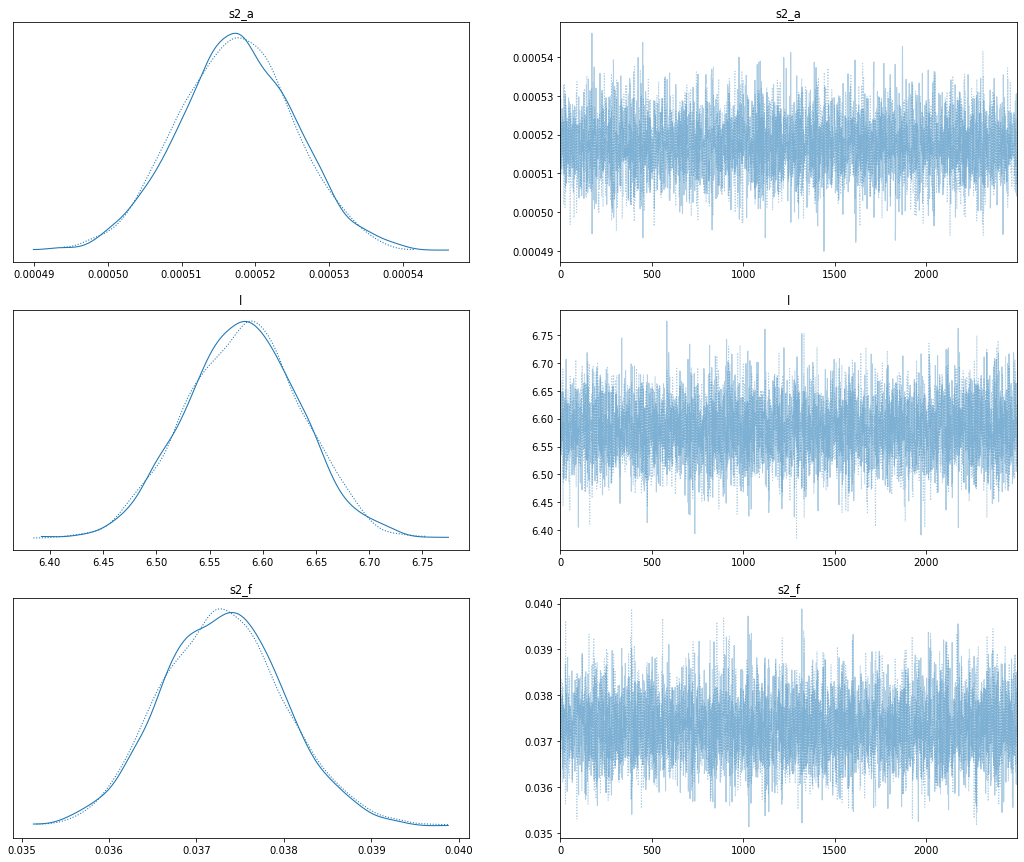

In [5]:
import arviz as az

_ = az.plot_trace(tr, var_names=["s2_a","l","s2_f"], figsize=((18, 15)))

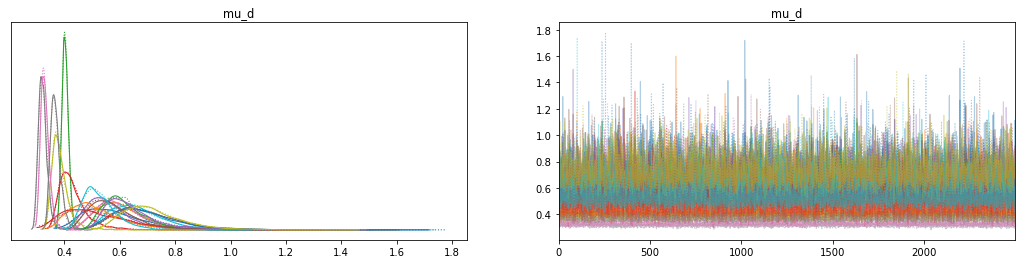

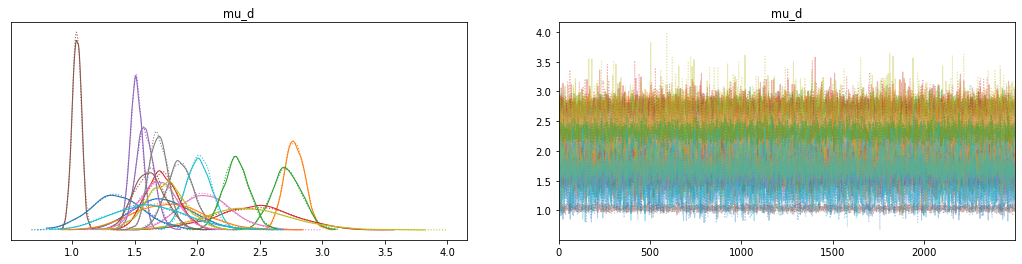

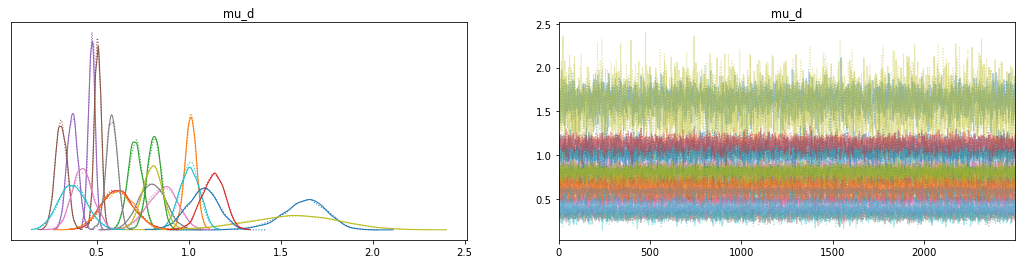

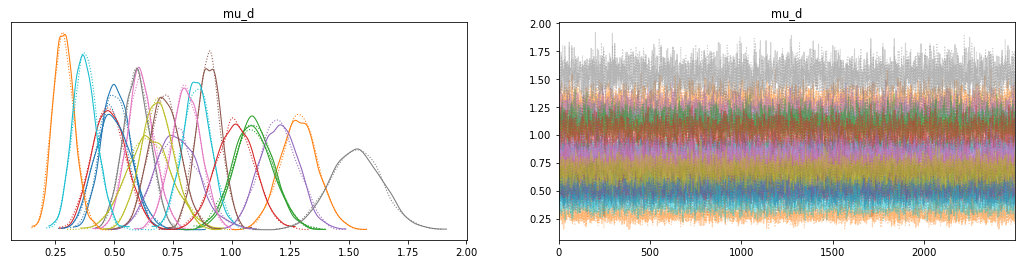

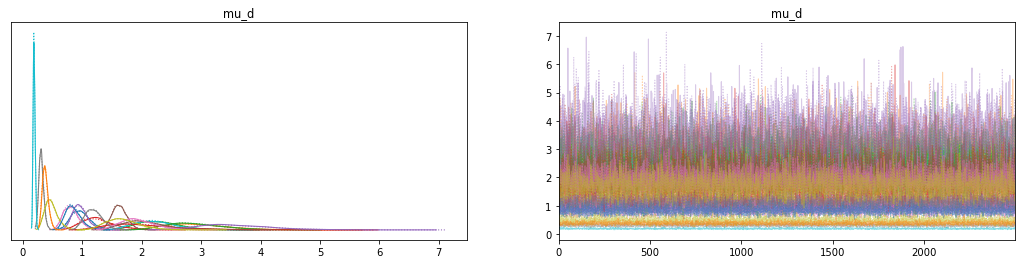

In [6]:
import arviz as az

_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":0}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":1}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":2}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":3}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":4}, figsize=((18, 4)),compact=True)

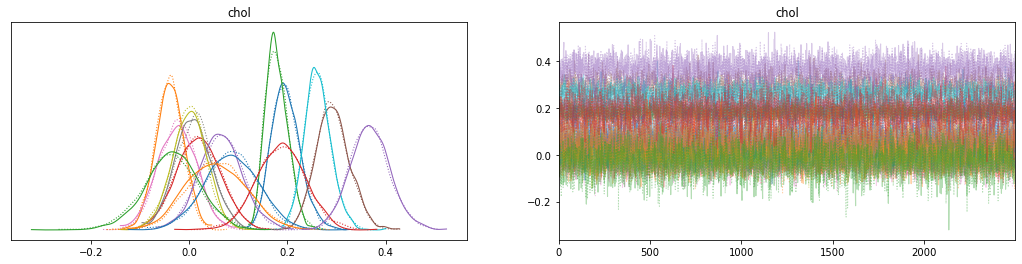

In [8]:
_ = az.plot_trace(tr, var_names=["chol"], figsize=((18, 4)),compact=True)

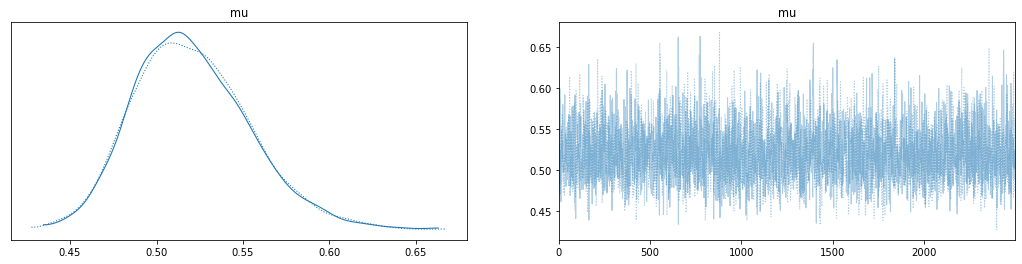

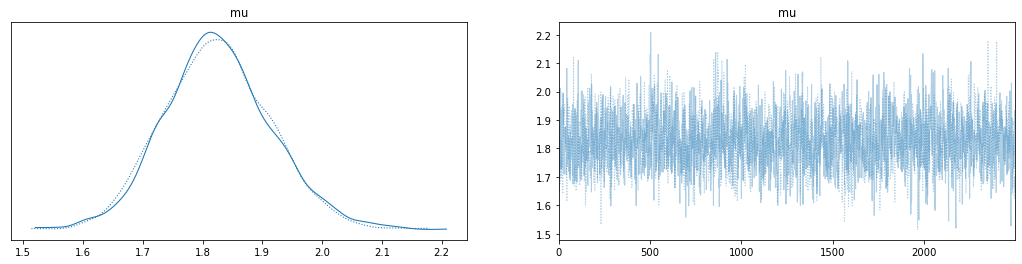

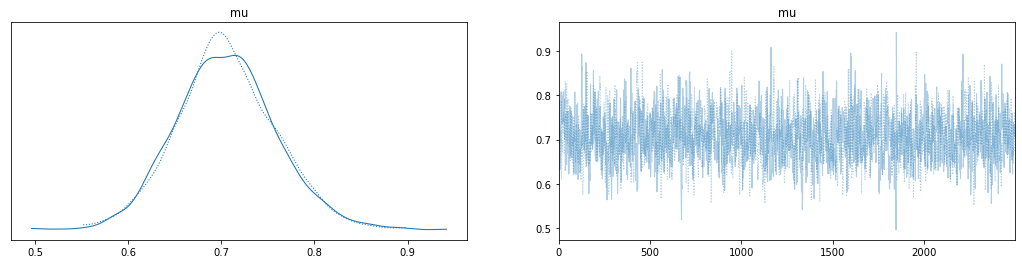

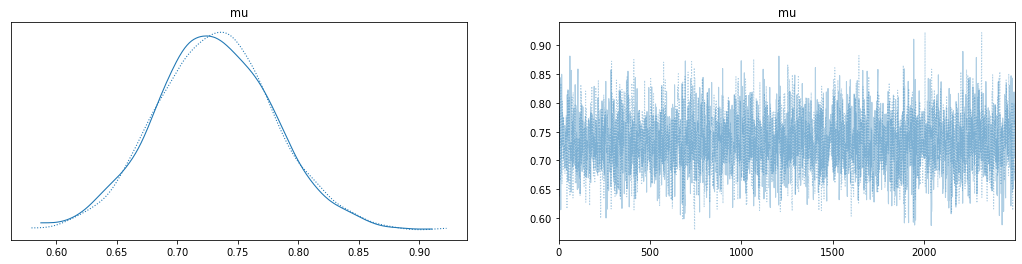

In [9]:
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":0}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":1}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":2}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":3}, figsize=((18, 4)),compact=True)

In [7]:
az.summary(tr, var_names=["mu"]) # index 0-5 are: VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA
# six IDM parameters for the population driver

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.521,0.034,0.462,0.586,0.001,0.000,3511.0,3324.0,1.0
mu[1],1.825,0.090,1.663,2.001,0.002,0.001,2066.0,2940.0,1.0
mu[2],0.706,0.054,0.607,0.809,0.001,0.001,1396.0,1980.0,1.0
mu[3],0.731,0.049,0.637,0.821,0.001,0.001,3896.0,3759.0,1.0
mu[4],1.185,0.126,0.967,1.441,0.002,0.002,3407.0,3033.0,1.0


In [11]:
az.summary(tr, var_names=["mu_d"], coords={"mu_d_dim_0":[0,10]})
# index 0-4 are: VMAX, DSAFE, TSAFE, AMAX, AMIN

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mu_d[0, 0]",0.595,0.135,0.388,0.845,0.002,0.002,3178.0,3603.0,1.0
"mu_d[0, 1]",1.727,0.240,1.294,2.189,0.004,0.003,4097.0,3713.0,1.0
"mu_d[0, 2]",1.627,0.124,1.394,1.851,0.002,0.001,4152.0,3702.0,1.0
"mu_d[0, 3]",0.508,0.062,0.387,0.619,0.001,0.001,5081.0,4117.0,1.0
"mu_d[0, 4]",0.975,0.166,0.690,1.297,0.002,0.002,4828.0,3960.0,1.0
"mu_d[10, 0]",0.695,0.128,0.499,0.925,0.002,0.001,4992.0,4058.0,1.0
"mu_d[10, 1]",1.357,0.212,0.937,1.738,0.003,0.002,4390.0,3878.0,1.0
"mu_d[10, 2]",1.074,0.085,0.923,1.236,0.001,0.001,4854.0,4061.0,1.0
"mu_d[10, 3]",0.497,0.076,0.357,0.637,0.001,0.001,5166.0,4273.0,1.0
"mu_d[10, 4]",0.850,0.135,0.622,1.105,0.002,0.001,5296.0,4195.0,1.0


In [12]:
az.summary(tr, var_names=["s2_a","l","s2_f"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
s2_a,0.001,0.000,0.001,0.001,0.000,0.0,6010.0,2839.0,1.0
l,6.581,0.054,6.479,6.682,0.001,0.0,6783.0,4086.0,1.0
s2_f,0.037,0.001,0.036,0.039,0.000,0.0,6763.0,3536.0,1.0


In [13]:
tr.posterior['mu_d'] = tr.posterior.mu_d[:,:,:,:] * [33, 2, 1.6, 1.5, 1.67]

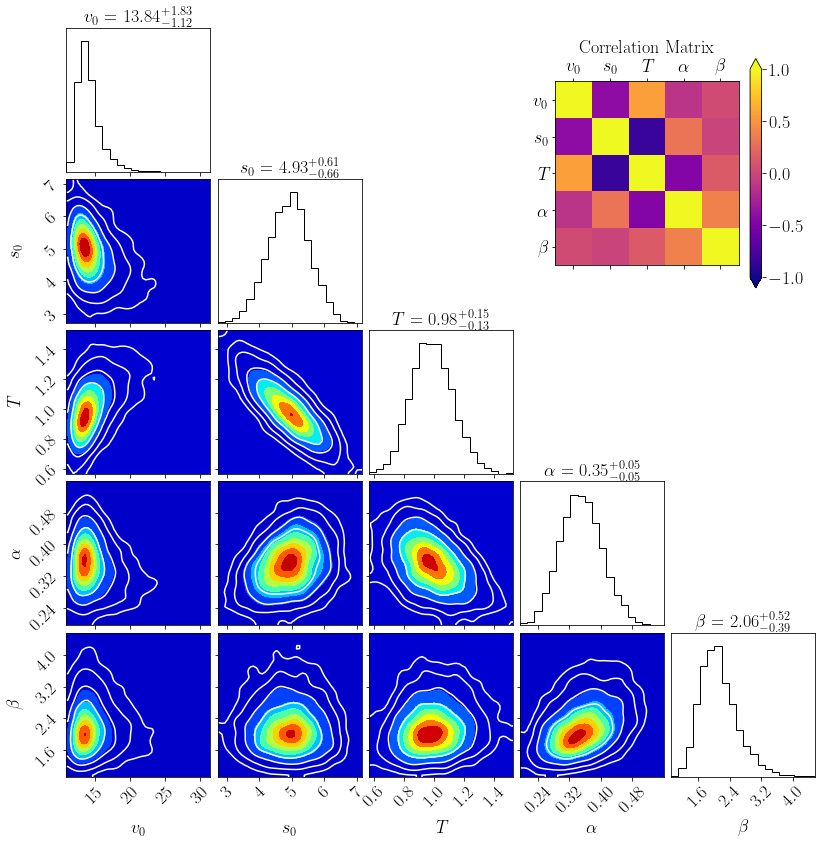

In [16]:
import corner

import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rcParams['font.family'] = 'Times New Roman'

driver_id = 3

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id},
    smooth=1.8,
    color = 'k',
    plot_contours=True,
    plot_density=False,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure_d.savefig('../Figs/MA_IDM_hierarchical_driver{:}.pdf'.format(driver_id), dpi=300)

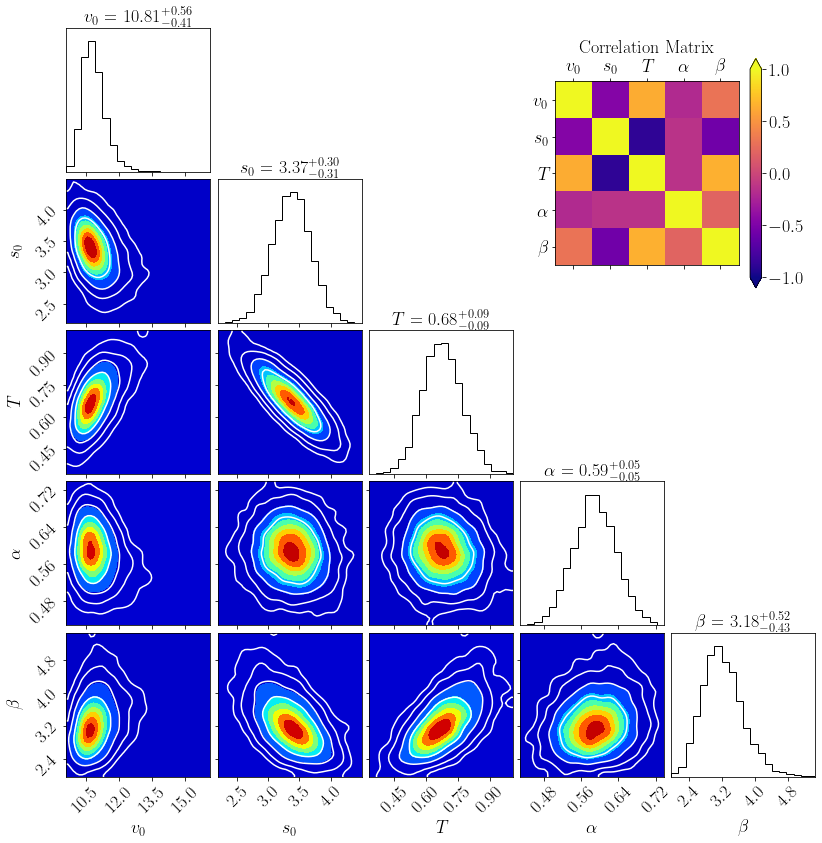

In [17]:
import corner

import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rcParams['font.family'] = 'Times New Roman'

driver_id = 16

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id},
    smooth=1.8,
    color = 'k',
    plot_contours=True,
    plot_density=False,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure_d.savefig('../Figs/MA_IDM_hierarchical_driver{:}.pdf'.format(driver_id), dpi=300)